In [32]:


# -*- coding: utf-8 -*-
"""
Created on Tue Apr 01 12:49:21 2022

@author: tamji
"""

import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from numpy import linalg as LA
import rdp_accountant
from rdp_accountant import compute_rdp  # pylint: disable=g-import-not-at-top
from rdp_accountant import get_privacy_spent
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from earlystop import EarlyStopping
import imageio
import time
import random
# import pyreadr as py





start = time.time()
df = pd.read_csv('./processed_household_power_consumption_new_hour.csv', delimiter=',')
df = df[['Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_4',
       'Global_active_power', 'years']]
df_train = df[df.years == 2006].sample(frac = 0.8).append(df[df.years == 2007].sample(frac = 0.8)).append(
    df[df.years == 2008].sample(frac = 0.8)).append(df[df.years == 2009].sample(frac = 0.8)).append(df[df.years == 2010].sample(frac = 0.8))

df_train = df_train[['Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_4',
       'Global_active_power']]

df = df[['Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_4',
       'Global_active_power']]

df_test = pd.concat([df,df_train]).drop_duplicates(keep=False)

x_train = df_train[df_train.columns[:-1]].copy().values
y_train = df_train[df_train.columns[-1:]].copy().values

x_test = df_test[df_test.columns[:-1]].copy().values
y_test = df_test[df_test.columns[-1:]].copy().values

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

#%%
class Parser:
    def __init__(self):
        self.epochs = 100
        self.lr = 0.001
        self.test_batch_size = 32
        self.batch_size = 32
        self.log_interval = 10
        self.seed = 1
    
args = Parser()
torch.manual_seed(args.seed)
#%%
mean = x_train.mean(0, keepdim=True)
dev = x_train.std(0, keepdim=True)
mean[:, int(len(mean[0])/2)] = 0.
dev[:, int(len(dev[0])/2)] = 1.
x_train = (x_train - mean) / dev
x_test = (x_test - mean) / dev
train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test)
#%%

class t_model(nn.Module):
    def __init__(self):
        super(t_model, self).__init__()
        self.fc1 = nn.Linear(7, 4)
        self.fc3 = nn.Linear(4, 2)
        self.fc2 = nn.Linear(2, 1)
    
    def forward(self, x):
        x = x.view(-1, 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        # x = F.relu(self.fc5(x))
        x = self.fc2(x)
        return x
#%%

#Return the samples that each client is going to have as a private training data set. This is a not overlapping set
def get_samples(num_clients, train_len):
    # tam = len(mnist_trainset)
    valid_size = 0.2
    tam = train_len
    split= int(tam/num_clients)
    split_ini = split
    indices = list(range(tam))
    np.random.shuffle(indices)
    init=0
    samples = []
    v_samples = []
    for i in range(num_clients):
        split_train = split - int(split_ini*valid_size)
        t_idx = indices[init:split_train]
        v_idx = indices[split_train:split]
        t_sampler = SubsetRandomSampler(t_idx)
        v_sampler = SubsetRandomSampler(v_idx)
        samples.append(t_sampler)
        v_samples.append(v_sampler)
        init = split
        split = split+split_ini
    return samples, v_samples

#%%

class client():
    def __init__(self, number, loader, v_loader, state_dict, batch_size = 32, epochs=10, lr=0.001):
        self.number = number
        self.model = t_model()
        self.model.load_state_dict(state_dict)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adamax(self.model.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience = 0)
        self.epochs = epochs
        self.device = torch.device("cuda:0""cuda:0" if torch.cuda.is_available() else "cpu")
        self.dataLoader = loader
        self.v_dataLoader = v_loader                  
                                           
    def update(self, state_dict, patience):     
        w0 = state_dict
        self.model.load_state_dict(state_dict)
        self.model.to(self.device)
        early_stopping = EarlyStopping(patience=patience, verbose=True)

        for e in range(self.epochs):
            # Model in training mode, dropout is on
            self.model.train()
            train_loss = 0.0
            valid_loss = 0.0
            for data, target in self.dataLoader:  
                data, target = data.to(self.device), target.to(self.device)                       
                self.optimizer.zero_grad()
                prediction = self.model(data)
                train_step_loss = F.mse_loss(prediction, target)
                train_step_loss.backward()
                lr = 0.001
                clip = 5
                torch.nn.utils.clip_grad_norm(self.model.parameters(),clip)
                for p in self.model.parameters():
                    p.data.add_(-lr, p.grad.data)
                self.optimizer.step() 
                train_loss += train_step_loss.item()        
                
            # validate the model
            self.model.eval()
            for data, target in self.v_dataLoader:
                data, target = data.to(self.device), target.to(self.device) 
                prediction = self.model(data)
                valid_step_loss = F.mse_loss(prediction, target)
                valid_loss += valid_step_loss.item()
            
            try:
                train_loss = train_loss/len(self.dataLoader.sampler)
                valid_loss = valid_loss/len(self.v_dataLoader.sampler)
                
                if (e > 20):
                    self.scheduler.step(valid_loss/len(self.v_dataLoader))

                early_stopping(valid_loss, self.model)
                if early_stopping.early_stop:
                    break
            except:
                train_loss = 0
                valid_loss = 0

                early_stopping(valid_loss, self.model)
                if early_stopping.early_stop:
                    break
                
        try:
            self.model.load_state_dict(torch.load('./checkpoint.pt'))   
        except:
            try:
                self.model.load_state_dict(torch.load('./checkpoint.pt'))   
            except:
                pass
        S ={} 
        wt1 = {}
        for key, value in w0.items():
            wt1[key] = self.model.state_dict()[key]  - value   
            S[key] = LA.norm(wt1[key].cpu(), 1)
        return wt1, S

#%%

def uniform_proposal(x, delta=2.0):
    return np.random.uniform(x - delta, x + delta)

def metropolis_sampler(p, nsamples, proposal=uniform_proposal):
    x = 1 # start somewhere

    for i in range(nsamples):
        trial = proposal(x) # random neighbour from the proposal distribution
        if ((p(x)!=0) | (p(x)!=0.0)):
            acceptance = p(trial)/p(x)
        else:
            acceptance = p(trial)
        # accept the move conditionally
        if np.random.uniform() < acceptance:
            x = trial
        yield x
  #%%

class server():
    def __init__(self, train, test, train_len, test_len, number_clients, p_budget, epsilon, sigmat):
        self.model = t_model()
        self.sigmat = sigmat   
        self.n_clients = number_clients
        self.samples, self.v_samples = get_samples(self.n_clients, train_len)
        self.clients = list()
        for i in range(number_clients):
            loader = DataLoader(train, batch_size=32, sampler=self.samples[i])
            # print(len(loader))
            v_loader = DataLoader(train, batch_size=32, sampler=self.v_samples[i])
            self.clients.append(client(i, loader,  v_loader, self.model.state_dict()))
        self.p_budget = p_budget
        self.epsilon = epsilon
        self.testLoader = torch.utils.data.DataLoader(test, batch_size=32)
        self.device = torch.device("cuda:0""cuda:0" if torch.cuda.is_available() else "cpu")
        self.orders = ([1.25, 1.5, 1.75, 2., 2.25, 2.5, 3., 3.5, 4., 4.5] +
                list(range(5, 64)) + [128, 256, 512])
    #Evaluates the accuracy of the current model with the test data.  
    def eval_acc(self):
        self.model.to(self.device)
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in self.testLoader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += F.mse_loss(output, target, reduction='sum').item()
            
        test_loss /= len(self.testLoader.dataset)
        print('Test set: Average loss: {:.4f}'.format(test_loss))
        return test_loss
    
    def sanitaze(self,mt, deltas, norms, sigma, state_dict, dpFlagNumber, FDIFlag, gamma, Cround, malModel):    
        inclMalSum_dict = {}
        exclMalSum_dict = {}
        onlyMalSum_dict = {}
        dicList = []
        
        for i in range(len(deltas)):
            without_state_dic = {}
            dicList.append(without_state_dic)
        
        for key, value in state_dict.items():
            S=[]
            for i in range(len(norms)):        
                S.append(norms[i][key])
            S_value = np.median(S)      
            wt = value
            try:
                prom = 1/float(mt)
            except:
                prom = 1/24
            inclMalSum = 0
            exclMalSum = 0
            onlyMalSum = 0
            modelSumList = []

            # print(len(deltas))
            for i in range(len(deltas)):    
                clip = (max(1, float(norms[i][key]/S_value)))
                clippedDelta = ((deltas[i][key])/clip)
                if ((FDIFlag == 0)):
                    noise = (np.random.normal(0, float((sigma**2)*(S_value**2)), size = clippedDelta.shape))
                else:
                    if ((i in malModel) &(Cround>10) & (Cround<30)):
                        noise = (np.random.normal((np.sqrt(2*gamma)*(sigma*S_value)), float((sigma**2)*(S_value**2)), size = clippedDelta.shape))
                    else:
                        noise = (np.random.normal(0, float((sigma**2)*(S_value**2)), size = clippedDelta.shape))
                            
                clippedDelta = clippedDelta.cpu().numpy()
                modelSum = clippedDelta + noise
                modelSumList.append(modelSum)
                inclMalSum = inclMalSum + modelSum
            
            
            inclMalSum = inclMalSum*prom
            
            # converting into torch
            inclMalSum = torch.from_numpy(inclMalSum)

            # adding with previous weights
            inclMalSum = wt + inclMalSum.float()
            
            # creating dictionary
            inclMalSum_dict[key] = inclMalSum
        
        return inclMalSum_dict

    def server_exec(self,mt, dpFlagNumber, patience, FDIFlag, gamma, case, malModel):   
        Cround=1
        testLossList = []
        inclMalTestLossList = []
        exclMalTestLossList = []
        onlyMalTestLossList = []
        
        while(True):
            # print('Comunication round: ', i)
            print('Case: ', case, ', Comunication round: ', Cround)
            test_loss = self.eval_acc()
            testLossList.append(test_loss) 
            rdp = compute_rdp(float(mt/len(self.clients)), self.sigmat, Cround, self.orders)
            _,delta_spent, opt_order = get_privacy_spent(self.orders, rdp, target_eps=self.epsilon)
            print('Delta spent: ', delta_spent)
            print('Delta budget: ', self.p_budget)  
            
            if dpFlagNumber!=0:
                if (self.p_budget < delta_spent):
                    break
            else:
                if i > 100:
                    break
            Zt = np.random.choice(self.clients, mt)      
            deltas = []
            norms = []
            for client in Zt:
                deltaW, normW = client.update(self.model.state_dict(), patience)   
                deltas.append(deltaW)
                norms.append(normW)
            self.model.to('cpu')

            inclMalSum_dict= self.sanitaze(mt, deltas, norms, self.sigmat, self.model.state_dict(), dpFlagNumber,
                                                                  FDIFlag, gamma, Cround, malModel)


            self.model.load_state_dict(inclMalSum_dict)

            Cround+=1
        return self.model, testLossList
#%%

########################################


dpFlag = [1]
FDIFlag = [1]

TclientList = [100]
PclientList = [30]
epsList = [1.0]
deltaList = [0.005]
gammaList = [8.0]
sigmaList = []
patience = 7



for i in range(len(epsList)):
    sigma = np.sqrt(2 * np.log(1.25 / deltaList[i])) * 1 / epsList[i]
    sigmaList.append(sigma+1.12)

train_len = len(x_train)
test_len = len(x_test)
non_mal_loss = []
incl_mal_loss = []
only_mal_loss = []
testLoss = []
LossL = []
malModel = [[5]]

for i in range(len(dpFlag)):
    case = i
    print("Case: ", case, " / DP: ", dpFlag[i], " / FDI: ", FDIFlag[i], " / K:", TclientList[i], " / n", PclientList[i], 
          " / e: ", epsList[i], " / d: ", " / g: ",gammaList[i], " / malModel: ", malModel[i])
    serv = server(train, test, train_len, test_len, TclientList[i], deltaList[i], epsList[i], sigmaList[i])
    model, testLossList  = serv.server_exec(PclientList[i],dpFlag[i],patience,FDIFlag[i],gammaList[i],case,malModel[i])
    ##########
    LossL.append(testLossList)
    model = t_model()

dfF = pd.DataFrame(LossL)
dfF = dfF.transpose()
dfF.columns = [  "K100_n30_e1"]
dfF.to_csv("./result/case2.csv", index = False)
end = time.time()
total_time = end-start
print("Total Time: ",total_time)


Case:  0  / DP:  1  / FDI:  1  / K: 100  / n 30  / e:  1.0  / d:   / g:  8.0  / malModel:  [5]
Case:  0 , Comunication round:  1
Test set: Average loss: 2.5346
Delta spent:  2.8074980897111023e-18
Delta budget:  0.005
Case:  0 , Comunication round:  2
Test set: Average loss: 1.6108
Delta spent:  6.740867835544171e-14
Delta budget:  0.005


KeyboardInterrupt: 

In [30]:
import pandas as pd

df01 = pd.read_csv("./final_outcome/case0_1.csv")
df02 = pd.read_csv("./final_outcome/case0_2.csv")
df03 = pd.read_csv("./final_outcome/case0_3.csv")

df04 = pd.read_csv("./final_outcome/case0_4.csv")
df05 = pd.read_csv("./final_outcome/case0_5.csv")

df1 = pd.read_csv("./final_outcome/case1_9.csv")
df2 = pd.read_csv("./final_outcome/case1_10.csv")
df3 = pd.read_csv("./final_outcome/case1_11.csv")

df11 = pd.read_csv("./final_outcome/case1_12.csv")
df12 = pd.read_csv("./final_outcome/case1_13.csv")
df13 = pd.read_csv("./final_outcome/case1_14.csv")

df4 = pd.read_csv("./final_outcome/case2_0.csv")
df5 = pd.read_csv("./final_outcome/case2_11.csv")
df6 = pd.read_csv("./final_outcome/case2_12.csv")
df7 = pd.read_csv("./final_outcome/case3_0.csv")
df8 = pd.read_csv("./final_outcome/case3_1.csv")
df9 = pd.read_csv("./final_outcome/case3_7.csv")

result = pd.concat([df01, df02, df03, df04, df05, df1, df2, df3, df11, df12, df13, df4, df5, df6, df7, df8, df9], axis=1)
# result = pd.concat([df1], axis=1)
print(result.columns)
result



Index(['K100_n30_a0_eps05_g1', 'K100_n30_a0_eps07_g1', 'K100_n30_a0_eps1_g1',
       'K100_n30_a0_eps05_g1_1', 'K100_n30_a1_eps05_g1_1',
       'K100_n30_a0_e07_g1', 'K100_n30_a1_e07_g1', 'K100_n30_a2_e07_g1',
       'K100_n30_a0_e07_g2', 'K100_n30_a1_e07_g2', 'K100_n30_a2_e07_g2',
       'K1000_n300_a0_e07_g2', 'K1000_n300_a7_e07_g2', 'K1000_n300_a0_e07_g3',
       'K1000_n300_a7_e07_g3', 'K10000_n3000_a0_e07_g2',
       'K10000_n3000_a70_e07_g2', 'K10000_n3000_a0_e07_g3',
       'K10000_n3000_a70_e07_g3'],
      dtype='object')


,K100_n30_a0_eps05_g1,K100_n30_a0_eps07_g1,K100_n30_a0_eps1_g1,K100_n30_a0_eps05_g1_1,K100_n30_a1_eps05_g1_1,K100_n30_a0_e07_g1,K100_n30_a1_e07_g1,K100_n30_a2_e07_g1,K100_n30_a0_e07_g2,K100_n30_a1_e07_g2,K100_n30_a2_e07_g2,K1000_n300_a0_e07_g2,K1000_n300_a7_e07_g2,K1000_n300_a0_e07_g3,K1000_n300_a7_e07_g3,K10000_n3000_a0_e07_g2,K10000_n3000_a70_e07_g2,K10000_n3000_a0_e07_g3,K10000_n3000_a70_e07_g3
0,2.569702,2.578801,2.591767,2.569702,2.613904,2.642274,2.673684,2.596030,2.642274,2.626227,2.539204,2.581820,2.564036,2.637810,2.943396,2.554881,2.604480,2.599524,3.129080
1,1.470281,0.985159,1.774807,1.470281,0.981018,1.966820,2.079632,0.821107,1.966820,2.091969,1.178056,2.356860,2.331106,2.414897,2.806418,2.419788,2.460716,2.466225,3.004475
2,1.269559,0.721392,0.961915,1.269559,1.177702,2.045742,1.232138,0.965861,2.045742,0.994902,0.485845,2.136169,2.092017,2.201344,2.673072,2.288528,2.316023,2.337205,2.952601
3,0.666283,0.611162,0.728735,0.666283,0.760561,1.038843,0.772352,1.102823,1.038843,0.620301,0.548541,1.931402,1.854057,2.002331,2.539941,2.159899,2.184564,2.213662,2.824700
4,0.621537,0.568084,0.590416,0.621537,0.632264,1.068054,0.378840,0.811239,1.068054,0.823231,0.957153,1.748918,1.619978,1.805182,2.433412,2.040524,2.060118,2.099390,2.705772
5,0.832066,0.547347,0.462513,0.832066,0.504383,0.641978,0.300823,1.247039,0.641978,0.669389,1.193389,1.577880,1.407809,1.625291,2.319030,1.927762,1.941813,1.987686,2.594797
6,0.762614,0.364117,0.415751,0.762614,0.506176,0.509980,0.337975,1.414618,0.509980,0.778991,1.031056,1.420267,1.199135,1.463535,2.221263,1.822856,1.828662,1.882344,2.488203
7,0.407665,0.378267,0.329327,0.407665,0.449310,0.347690,0.331675,1.711034,0.347690,0.669292,0.990171,1.291372,1.035831,1.313883,2.119918,1.720380,1.716893,1.781262,2.389875
8,0.761444,0.270972,0.388569,0.761444,0.411581,0.208025,0.314588,1.533998,0.208025,0.407405,0.546985,1.158967,0.901579,1.191489,2.036587,1.628613,1.610044,1.687378,2.293303
9,1.519462,0.240860,0.241248,1.519462,0.413634,0.160786,0.254305,1.370663,0.160786,0.423257,0.810322,1.050603,0.814213,1.082198,1.950460,1.545204,1.507289,1.598409,2.206069


<IPython.core.display.Javascript object>


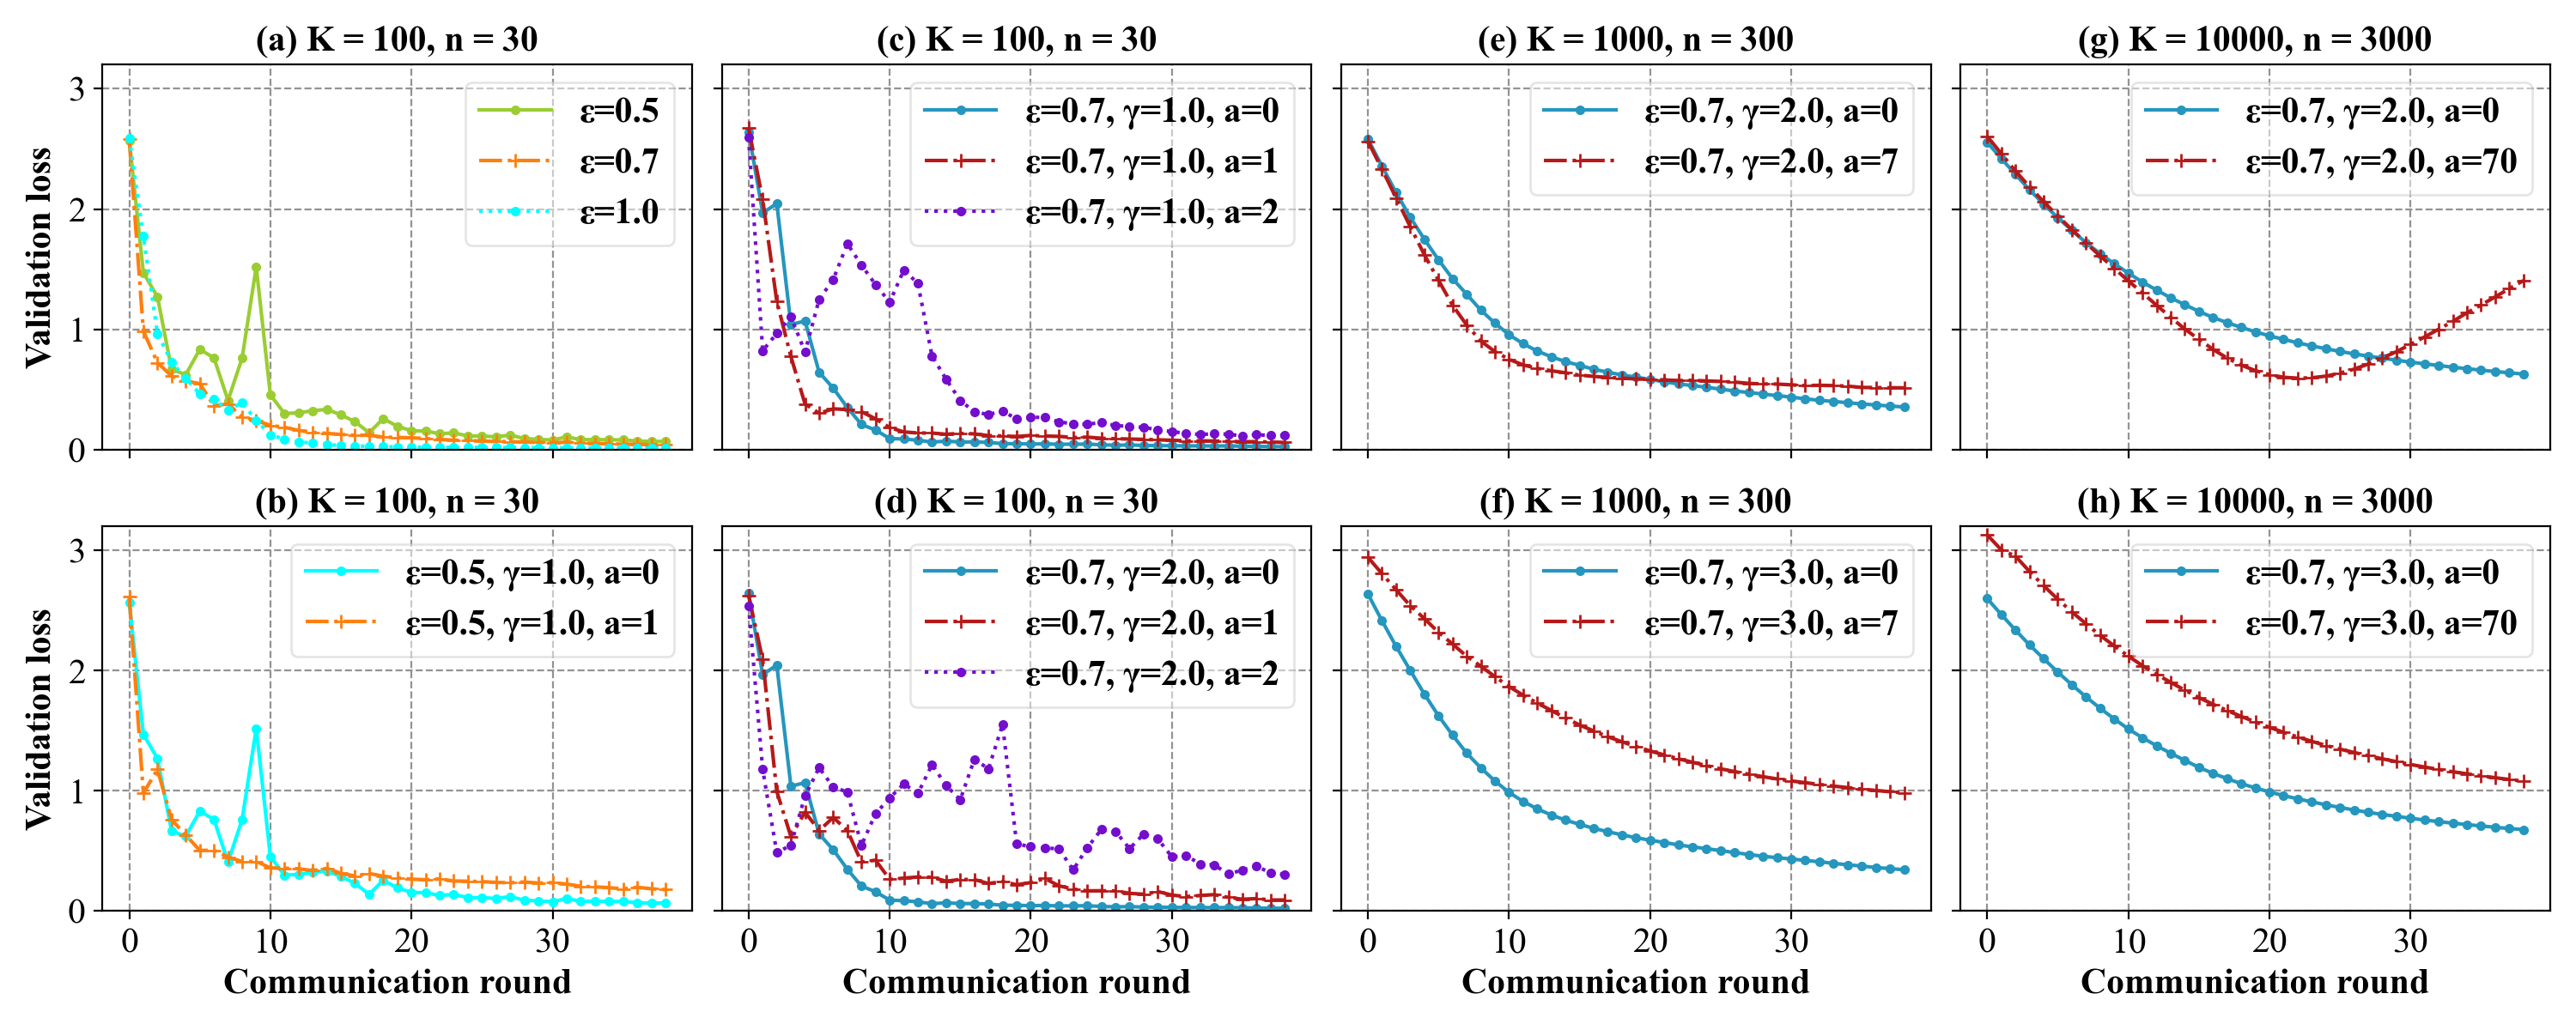

In [31]:
from matplotlib import rcParams, cycler
from matplotlib.lines import Line2D
from matplotlib.pyplot import cm
import random
from matplotlib import cbook
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.gridspec as gridspec

plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#949292"
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['font.sans-serif'] = "Times New Roman"
plt.rcParams['font.family'] = "sans-serif"
legend_properties = {'weight':'bold'}

fig = plt.figure(figsize=(15, 6))


ax0 = fig.add_subplot(2,4,1)
ax1 = fig.add_subplot(2,4,2) 
ax2 = fig.add_subplot(2,4,3) 
ax3 = fig.add_subplot(2,4,4)
ax4 = fig.add_subplot(2,4,5)
ax5 = fig.add_subplot(2,4,6) 
ax6 = fig.add_subplot(2,4,7) 
ax7 = fig.add_subplot(2,4,8) 

# fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,7))
ax0.plot(result.K100_n30_a0_eps05_g1, marker= '.', linestyle='-', color='#9ACd32', label = 'ε=0.5')
ax0.plot(result.K100_n30_a0_eps07_g1, marker = "+", linestyle='-.', color = '#ff7f0e', label = 'ε=0.7')
ax0.plot(result.K100_n30_a0_eps1_g1, marker = ".", linestyle=':', color = 'cyan', label = 'ε=1.0')

ax1.plot(result.K100_n30_a0_e07_g1, marker= '.', linestyle='-', color='#2596be', label = 'ε=0.7, γ=1.0, a=0')
ax1.plot(result.K100_n30_a1_e07_g1, marker = "+", linestyle='-.', color = '#B61919', label = 'ε=0.7, γ=1.0, a=1')
ax1.plot(result.K100_n30_a2_e07_g1, marker = ".", linestyle=':', color = '#740ecd', label = 'ε=0.7, γ=1.0, a=2')

ax2.plot(result.K1000_n300_a0_e07_g2, marker= '.', linestyle='-', color='#2596be', label = 'ε=0.7, γ=2.0, a=0')
ax2.plot(result.K1000_n300_a7_e07_g2, marker = "+", linestyle='-.', color = '#B61919', label = 'ε=0.7, γ=2.0, a=7')

ax3.plot(result.K10000_n3000_a0_e07_g2, marker= '.', linestyle='-', color='#2596be', label = 'ε=0.7, γ=2.0, a=0')
ax3.plot(result.K10000_n3000_a70_e07_g2, marker = "+", linestyle='-.', color = '#B61919', label = 'ε=0.7, γ=2.0, a=70')

ax4.plot(result.K100_n30_a0_eps05_g1_1, marker= '.', linestyle='-', color='cyan', label = 'ε=0.5, γ=1.0, a=0')
ax4.plot(result.K100_n30_a1_eps05_g1_1, marker = "+", linestyle='-.', color = '#ff7f0e', label = 'ε=0.5, γ=1.0, a=1')

ax5.plot(result.K100_n30_a0_e07_g2, marker= '.', linestyle='-', color='#2596be',label = 'ε=0.7, γ=2.0, a=0')
ax5.plot(result.K100_n30_a1_e07_g2, marker = "+", linestyle='-.', color = '#B61919', label = 'ε=0.7, γ=2.0, a=1')
ax5.plot(result.K100_n30_a2_e07_g2, marker = ".", linestyle=':', color = '#740ecd', label = 'ε=0.7, γ=2.0, a=2')

ax6.plot(result.K1000_n300_a0_e07_g3, marker= '.', linestyle='-', color='#2596be', label = 'ε=0.7, γ=3.0, a=0')
ax6.plot(result.K1000_n300_a7_e07_g3, marker = "+", linestyle='-.', color = '#B61919', label = 'ε=0.7, γ=3.0, a=7')

ax7.plot(result.K10000_n3000_a0_e07_g3, marker= '.', linestyle='-', color='#2596be', label = 'ε=0.7, γ=3.0, a=0')
ax7.plot(result.K10000_n3000_a70_e07_g3, marker = "+", linestyle='-.', color = '#B61919', label = 'ε=0.7, γ=3.0, a=70')


# ax4.plot(dfF.K1000_n200_a0_e09_g3, label = 'e=0.9, γ=3.0, a=0')
# ax4.plot(dfF.K1000_n300_a15_e09_g3, label = 'e=0.9, γ=3.0, a=15')

# ax1.legend()
# ax2.legend()
# ax3.legend()
# ax4.legend()
# ax5.legend()
# ax6.legend()

# ax1.grid()
# ax2.grid()
# ax3.grid()
# ax4.grid()
# ax5.grid()
# ax6.grid()

for ax in fig.get_axes():
    ax.legend()
    ax.set_ylim(0,3.2)
    ax.set_ylabel('Validation loss', fontsize=15, fontweight='bold')
    ax.set_xlabel('Communication round', fontsize=15, fontweight='bold')
    ax.label_outer()
    ax.grid()
    ax.tick_params(axis='x', labelsize= 15 )
    ax.tick_params(axis='y', labelsize= 15 )
    ax.xaxis.get_major_locator().set_params(nbins=8)
    ax.yaxis.get_major_locator().set_params(nbins=4)
#     ax.set_aspect('equal')
    ax.legend(prop={'weight':'bold', 'size':15}, 
           labelcolor='black', fancybox=True,framealpha=0.5, loc="upper right")
ax0.set_title('(a) K = 100, n = 30', fontsize=15, fontweight='bold')
ax1.set_title('(c) K = 100, n = 30', fontsize=15, fontweight='bold')
ax2.set_title('(e) K = 1000, n = 300', fontsize=15, fontweight='bold')  
ax3.set_title('(g) K = 10000, n = 3000', fontsize=15, fontweight='bold')  
ax4.set_title('(b) K = 100, n = 30', fontsize=15, fontweight='bold')  
ax5.set_title('(d) K = 100, n = 30', fontsize=15, fontweight='bold')  
ax6.set_title('(f) K = 1000, n = 300', fontsize=15, fontweight='bold')  
ax7.set_title('(h) K = 10000, n = 3000', fontsize=15, fontweight='bold')  


#..............................................................................................................
# axins2 = zoomed_inset_axes(ax1, zoom=2, loc=5)
# axins2.plot(result.K100_n30_a0_e07_g1, marker = '.', linestyle='-', color ='#2596be', label='ε=0.7, γ=1.0, a=0')
# axins2.plot(result.K100_n30_a1_e07_g1, marker= '+', linestyle='-.', color='#B61919', label="ε=0.7, γ=1.0, a=1")
# axins2.plot(result.K100_n30_a2_e07_g1, marker = ".", linestyle=':', color = '#740ecd', label="ε=0.7, γ=1.0, a=2")

# # # sub region of the original image
# x1, x2, y1, y2 = 30,39,-0.1, 0.3
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)
# # # fix the number of ticks on the inset axes
# axins2.yaxis.get_major_locator().set_params(nbins=1)
# axins2.xaxis.get_major_locator().set_params(nbins=6)

# plt.setp(axins2.get_xticklabels(), visible=True)
# plt.setp(axins2.get_yticklabels(), visible=True)

# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# # plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# # # draw a bbox of the region of the inset axes in the parent axes and
# # # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=1, fc="0.85", ec="0.5")
# ax1.indicate_inset_zoom(axins2, edgecolor="black")
#..............................................................................................................


fig.tight_layout()
plt.subplots_adjust(wspace= 0.05, hspace= 0.2)
plt.show()
